# Import Libraries

In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords

import re

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score

import keras
from keras.preprocessing import text,sequence
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import codecs
from tqdm import tqdm

# Load Dataset

## Dataset Crawling

In [2]:
news_data = pd.read_csv('datatambahan.csv', delimiter=",")

In [3]:
news_data.head(5)

,waktu,username,title text,label
0,2022-06-06 03:03:32+00:00,GoRiauCom,Pelaku Pemukulan Brutal Terhadap Anak Anggota ...,true
1,2022-06-06 03:03:31+00:00,NgobrolO,Panglima Didukung Segera Tumpas Teroris KKB di...,true
2,2022-06-06 03:03:18+00:00,NRumbrewar,CCIPP tingkatkan kualitas SDM untuk dukung IKN...,true
3,2022-06-06 03:03:15+00:00,NRumbrewar,Survei SMRC: Kepuasan pada Kerja Jokowi Naik J...,true
4,2022-06-06 03:02:55+00:00,farrel27,Erick Thohir ajak Puan Retno dan Triawan ke Sa...,true


In [4]:
news_datafinal = news_data[['title text','label']]

In [5]:
news_datafinal.head(5)

,title text,label
0,Pelaku Pemukulan Brutal Terhadap Anak Anggota ...,true
1,Panglima Didukung Segera Tumpas Teroris KKB di...,true
2,CCIPP tingkatkan kualitas SDM untuk dukung IKN...,true
3,Survei SMRC: Kepuasan pada Kerja Jokowi Naik J...,true
4,Erick Thohir ajak Puan Retno dan Triawan ke Sa...,true


In [6]:
news_datafinal['label'].value_counts()

true         280
clickbait      3
false          1
true           1
Name: label, dtype: int64

In [7]:
news_datafinal.drop(news_datafinal[news_datafinal['label'] == "true "].index, inplace = True)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_21180\788908400.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_datafinal.drop(news_datafinal[news_datafinal['label'] == "true "].index, inplace = True)


In [8]:
news_datafinal['label'].value_counts()

true         280
clickbait      3
false          1
Name: label, dtype: int64

## Dataset Clickbait DetikNews

In [9]:
clickbait_detiknews = pd.read_csv('annotated_detikNews.csv')

In [10]:
clickbait_detiknews.rename(columns = {"title": "title text"}, inplace=True)

In [11]:
clickbait_detiknews

,title text,label,label_score
0,"Masuk Radar Pilwalkot Medan, Menantu Jokowi Be...",non-clickbait,0
1,Malaysia Sudutkan RI: Isu Kabut Asap hingga In...,non-clickbait,0
2,Viral! Driver Ojol di Bekasi Antar Pesanan Mak...,clickbait,1
3,"Kemensos Salurkan Rp 7,3 M bagi Korban Kerusuh...",non-clickbait,0
4,"Terkait Mayat Bayi Mengenaskan di Tangerang, S...",non-clickbait,0
...,...,...,...
995,Gibran Rakabuming Angkat Bicara Soal Spandukny...,non-clickbait,0
996,Warga yang Terkena ISPA Akibat Karhutla Capai ...,non-clickbait,0
997,Ratusan Mahasiswa di Malang Tuntut Pencabutan ...,non-clickbait,0
998,"Rusuh di Jayapura: 1 Prajurit TNI Gugur, 6 Ang...",non-clickbait,0


In [12]:
clickbait_detiknews['label_score'].value_counts()

0    890
1    110
Name: label_score, dtype: int64

In [13]:
clickbait_detiknews.drop(clickbait_detiknews[clickbait_detiknews['label_score'] == 0].index, inplace = True)

In [14]:
clickbait_detiknews

,title text,label,label_score
2,Viral! Driver Ojol di Bekasi Antar Pesanan Mak...,clickbait,1
11,"Ada Motor Nyangkut di Atas Bambu di Sleman, Ko...",clickbait,1
13,Pesan Gamblang Poyuono Menolak Revisi UU KPK,clickbait,1
37,Detik-detik Lima Kendaraan Alami Kecelakaan Be...,clickbait,1
38,Kocak! Maling di Rumah Mewah Jakut Terekam CCT...,clickbait,1
...,...,...,...
945,"Heboh Timbangan Beras BPNT Berkurang, Ini Kata...",clickbait,1
951,Viral Cuitan 'Sekolah yang Pinter Biar Gajadi ...,clickbait,1
976,"Demo di Mana-mana, Jokowi Sedang Panggil Pejab...",clickbait,1
978,DPR Bakal Sahkan RUU Keamanan Siber 30 September?,clickbait,1


In [15]:
clickbaitdn_final = clickbait_detiknews[['title text','label']]

In [16]:
clickbaitdn_final.head(5)

,title text,label
2,Viral! Driver Ojol di Bekasi Antar Pesanan Mak...,clickbait
11,"Ada Motor Nyangkut di Atas Bambu di Sleman, Ko...",clickbait
13,Pesan Gamblang Poyuono Menolak Revisi UU KPK,clickbait
37,Detik-detik Lima Kendaraan Alami Kecelakaan Be...,clickbait
38,Kocak! Maling di Rumah Mewah Jakut Terekam CCT...,clickbait


## Dataset Clickbait Kompas

In [17]:
clickbait_kompas = pd.read_csv('annotated_kompas.csv')

In [18]:
clickbait_kompas.rename(columns = {"title": "title text"}, inplace=True)

In [19]:
clickbait_kompas

,title text,label,label_score
0,"Diduga Pasok Sabu di Anambas, Adik Wali Kota T...",non-clickbait,0
1,Wanita dengan Tubuh Berisi Terbukti Bikin Pria...,clickbait,1
2,Kronologi Lengkap Pemuda di Bandung Tusuk Gadi...,clickbait,1
3,Pemain Thailand Beri Hormat ke Suporter Indone...,non-clickbait,0
4,"Kualitas Udara di Pontianak Berbahaya, Dinas K...",non-clickbait,0
...,...,...,...
1495,"Peras Pembeli Narkoba hingga Rp 500 Juta, Tiga...",non-clickbait,0
1496,KPK Punya Kewenangan Menerbitkan SP3 dengan Ja...,non-clickbait,0
1497,BPK Janji Bakal Beberkan Audit Lahan dan Izin ...,non-clickbait,0
1498,Melihat Tren Busana Pria di Plaza Indonesia Me...,clickbait,1


In [20]:
clickbait_kompas['label_score'].value_counts()

0    1157
1     343
Name: label_score, dtype: int64

In [21]:
clickbait_kompas.drop(clickbait_kompas[clickbait_kompas['label_score'] == 0].index, inplace = True)

In [22]:
clickbait_kompas

,title text,label,label_score
1,Wanita dengan Tubuh Berisi Terbukti Bikin Pria...,clickbait,1
2,Kronologi Lengkap Pemuda di Bandung Tusuk Gadi...,clickbait,1
5,"Sarapan Bikin Ngantuk, Mitos atau Fakta?",clickbait,1
8,"Pikap Tabrak Rumah di Kebon Jeruk, 2 Penghuni ...",clickbait,1
10,"Unggah Foto Bersama Habibie, Syahrini: Semoga ...",clickbait,1
...,...,...,...
1477,Kucumbu Tubuh Indahku Wakili Indonesia di Osca...,clickbait,1
1481,"Gaji Lebih Rendah dari Anggota, Mengapa Zita A...",clickbait,1
1489,Cara Polisi Tindak Pelanggar Ganjil Genap Agar...,clickbait,1
1492,"Napoli Vs Liverpool, Tekad Tuan Rumah Kalahkan...",clickbait,1


In [23]:
clickbaitkompas_final = clickbait_kompas[['title text','label']]

In [24]:
clickbaitkompas_final.head(5)

,title text,label
1,Wanita dengan Tubuh Berisi Terbukti Bikin Pria...,clickbait
2,Kronologi Lengkap Pemuda di Bandung Tusuk Gadi...,clickbait
5,"Sarapan Bikin Ngantuk, Mitos atau Fakta?",clickbait
8,"Pikap Tabrak Rumah di Kebon Jeruk, 2 Penghuni ...",clickbait
10,"Unggah Foto Bersama Habibie, Syahrini: Semoga ...",clickbait


## Merging Data

In [25]:
#Merging Dataset (Data Crawling dan Clickbait)
dataset_news = pd.concat([news_datafinal, clickbaitdn_final, clickbaitkompas_final], ignore_index=True, sort=False)

In [26]:
dataset_news

,title text,label
0,Pelaku Pemukulan Brutal Terhadap Anak Anggota ...,true
1,Panglima Didukung Segera Tumpas Teroris KKB di...,true
2,CCIPP tingkatkan kualitas SDM untuk dukung IKN...,true
3,Survei SMRC: Kepuasan pada Kerja Jokowi Naik J...,true
4,Erick Thohir ajak Puan Retno dan Triawan ke Sa...,true
...,...,...
738,Kucumbu Tubuh Indahku Wakili Indonesia di Osca...,clickbait
739,"Gaji Lebih Rendah dari Anggota, Mengapa Zita A...",clickbait
740,Cara Polisi Tindak Pelanggar Ganjil Genap Agar...,clickbait
741,"Napoli Vs Liverpool, Tekad Tuan Rumah Kalahkan...",clickbait


In [27]:
datasetnews = dataset_news.dropna()

In [28]:
datasetnews['label'].value_counts()

clickbait    456
true         280
false          1
Name: label, dtype: int64

In [29]:
datasetnews

,title text,label
0,Pelaku Pemukulan Brutal Terhadap Anak Anggota ...,true
1,Panglima Didukung Segera Tumpas Teroris KKB di...,true
2,CCIPP tingkatkan kualitas SDM untuk dukung IKN...,true
3,Survei SMRC: Kepuasan pada Kerja Jokowi Naik J...,true
4,Erick Thohir ajak Puan Retno dan Triawan ke Sa...,true
...,...,...
738,Kucumbu Tubuh Indahku Wakili Indonesia di Osca...,clickbait
739,"Gaji Lebih Rendah dari Anggota, Mengapa Zita A...",clickbait
740,Cara Polisi Tindak Pelanggar Ganjil Genap Agar...,clickbait
741,"Napoli Vs Liverpool, Tekad Tuan Rumah Kalahkan...",clickbait


## Dataset Fake News

In [30]:
dfake = pd.read_csv('Data_latih.csv')
dfake

,ID,label,tanggal,judul,narasi,nama file gambar
0,71,1,17-Aug-20,Pemakaian Masker Menyebabkan Penyakit Legionna...,A caller to a radio talk show recently shared ...,71.jpg
1,461,1,17-Jul-20,Instruksi Gubernur Jateng tentang penilangan ...,Yth.Seluruh Anggota Grup Sesuai Instruksi Gube...,461.png
2,495,1,13-Jul-20,Foto Jim Rohn: Jokowi adalah presiden terbaik ...,Jokowi adalah presiden terbaik dlm sejarah ban...,495.png
3,550,1,8-Jul-20,"ini bukan politik, tapi kenyataan Pak Jokowi b...","Maaf Mas2 dan Mbak2, ini bukan politik, tapi k...",550.png
4,681,1,24-Jun-20,Foto Kadrun kalo lihat foto ini panas dingin,Kadrun kalo lihat foto ini panas dingin . .,681.jpg
...,...,...,...,...,...,...
4226,999287,1,17-Jan-16,: KPK Dilarang Membawa Brimob Bersenjata Masuk...,KPK Dilarang Membawa Brimob Bersenjata Masuk G...,999287.jpg
4227,999472,1,20-Aug-20,Foto pejabat keuangan dibawah palu arit,Jangan mau dialihkan kepada pakaian adat… FOKU...,999472.png
4228,999501,1,17-Aug-20,Gambar Denny Siregar Musuh Warga Tasikmalaya d...,Akhir nya bisa terkenal bang denny,999501.jpg
4229,999848,1,21-Jul-20,Kaesang: Bapak Saya dengan Kesederhaan Bisa Ni...,Bapak Saya dengan Kesederhaan Bisa Nipu Rakyat...,999848.jpg


In [31]:
dfake.drop(dfake[dfake['label'] == 0].index, inplace = True)
dfake

,ID,label,tanggal,judul,narasi,nama file gambar
0,71,1,17-Aug-20,Pemakaian Masker Menyebabkan Penyakit Legionna...,A caller to a radio talk show recently shared ...,71.jpg
1,461,1,17-Jul-20,Instruksi Gubernur Jateng tentang penilangan ...,Yth.Seluruh Anggota Grup Sesuai Instruksi Gube...,461.png
2,495,1,13-Jul-20,Foto Jim Rohn: Jokowi adalah presiden terbaik ...,Jokowi adalah presiden terbaik dlm sejarah ban...,495.png
3,550,1,8-Jul-20,"ini bukan politik, tapi kenyataan Pak Jokowi b...","Maaf Mas2 dan Mbak2, ini bukan politik, tapi k...",550.png
4,681,1,24-Jun-20,Foto Kadrun kalo lihat foto ini panas dingin,Kadrun kalo lihat foto ini panas dingin . .,681.jpg
...,...,...,...,...,...,...
4226,999287,1,17-Jan-16,: KPK Dilarang Membawa Brimob Bersenjata Masuk...,KPK Dilarang Membawa Brimob Bersenjata Masuk G...,999287.jpg
4227,999472,1,20-Aug-20,Foto pejabat keuangan dibawah palu arit,Jangan mau dialihkan kepada pakaian adat… FOKU...,999472.png
4228,999501,1,17-Aug-20,Gambar Denny Siregar Musuh Warga Tasikmalaya d...,Akhir nya bisa terkenal bang denny,999501.jpg
4229,999848,1,21-Jul-20,Kaesang: Bapak Saya dengan Kesederhaan Bisa Ni...,Bapak Saya dengan Kesederhaan Bisa Nipu Rakyat...,999848.jpg


In [32]:
dfake.dropna()

,ID,label,tanggal,judul,narasi,nama file gambar
0,71,1,17-Aug-20,Pemakaian Masker Menyebabkan Penyakit Legionna...,A caller to a radio talk show recently shared ...,71.jpg
1,461,1,17-Jul-20,Instruksi Gubernur Jateng tentang penilangan ...,Yth.Seluruh Anggota Grup Sesuai Instruksi Gube...,461.png
2,495,1,13-Jul-20,Foto Jim Rohn: Jokowi adalah presiden terbaik ...,Jokowi adalah presiden terbaik dlm sejarah ban...,495.png
3,550,1,8-Jul-20,"ini bukan politik, tapi kenyataan Pak Jokowi b...","Maaf Mas2 dan Mbak2, ini bukan politik, tapi k...",550.png
4,681,1,24-Jun-20,Foto Kadrun kalo lihat foto ini panas dingin,Kadrun kalo lihat foto ini panas dingin . .,681.jpg
...,...,...,...,...,...,...
4226,999287,1,17-Jan-16,: KPK Dilarang Membawa Brimob Bersenjata Masuk...,KPK Dilarang Membawa Brimob Bersenjata Masuk G...,999287.jpg
4227,999472,1,20-Aug-20,Foto pejabat keuangan dibawah palu arit,Jangan mau dialihkan kepada pakaian adat… FOKU...,999472.png
4228,999501,1,17-Aug-20,Gambar Denny Siregar Musuh Warga Tasikmalaya d...,Akhir nya bisa terkenal bang denny,999501.jpg
4229,999848,1,21-Jul-20,Kaesang: Bapak Saya dengan Kesederhaan Bisa Ni...,Bapak Saya dengan Kesederhaan Bisa Nipu Rakyat...,999848.jpg


In [33]:
dfake_new = dfake[['judul', 'label']]

In [34]:
dfake_new

,judul,label
0,Pemakaian Masker Menyebabkan Penyakit Legionna...,1
1,Instruksi Gubernur Jateng tentang penilangan ...,1
2,Foto Jim Rohn: Jokowi adalah presiden terbaik ...,1
3,"ini bukan politik, tapi kenyataan Pak Jokowi b...",1
4,Foto Kadrun kalo lihat foto ini panas dingin,1
...,...,...
4226,: KPK Dilarang Membawa Brimob Bersenjata Masuk...,1
4227,Foto pejabat keuangan dibawah palu arit,1
4228,Gambar Denny Siregar Musuh Warga Tasikmalaya d...,1
4229,Kaesang: Bapak Saya dengan Kesederhaan Bisa Ni...,1


In [35]:
dfakes = dfake_new.head(300)
dfakes

,judul,label
0,Pemakaian Masker Menyebabkan Penyakit Legionna...,1
1,Instruksi Gubernur Jateng tentang penilangan ...,1
2,Foto Jim Rohn: Jokowi adalah presiden terbaik ...,1
3,"ini bukan politik, tapi kenyataan Pak Jokowi b...",1
4,Foto Kadrun kalo lihat foto ini panas dingin,1
...,...,...
347,Penemuan Mayat Seorang Anak Kelas Satu SDN Pad...,1
348,NOMOR PORSI HAJI KEBERANGKATAN TAHUN 2018 HING...,1
349,"Indonesia ku sayang, Indonesia ku malang",1
350,PEMOGE TEWAS DI JALUR ALTERNATIF CIKIDANG,1


In [36]:
dfakes.columns.values

array(['judul', 'label'], dtype=object)

In [37]:
dfakes.rename(columns = {"judul": "title text"}, inplace=True)
dfakes

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_21180\3250198376.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfakes.rename(columns = {"judul": "title text"}, inplace=True)


,title text,label
0,Pemakaian Masker Menyebabkan Penyakit Legionna...,1
1,Instruksi Gubernur Jateng tentang penilangan ...,1
2,Foto Jim Rohn: Jokowi adalah presiden terbaik ...,1
3,"ini bukan politik, tapi kenyataan Pak Jokowi b...",1
4,Foto Kadrun kalo lihat foto ini panas dingin,1
...,...,...
347,Penemuan Mayat Seorang Anak Kelas Satu SDN Pad...,1
348,NOMOR PORSI HAJI KEBERANGKATAN TAHUN 2018 HING...,1
349,"Indonesia ku sayang, Indonesia ku malang",1
350,PEMOGE TEWAS DI JALUR ALTERNATIF CIKIDANG,1


In [38]:
def convert(polarity):
    if polarity == 1:
        return "false"
    else:
        return 0

dfakes['label'] = dfakes['label'].apply(convert)
dfakes

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_21180\998280808.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfakes['label'] = dfakes['label'].apply(convert)


,title text,label
0,Pemakaian Masker Menyebabkan Penyakit Legionna...,false
1,Instruksi Gubernur Jateng tentang penilangan ...,false
2,Foto Jim Rohn: Jokowi adalah presiden terbaik ...,false
3,"ini bukan politik, tapi kenyataan Pak Jokowi b...",false
4,Foto Kadrun kalo lihat foto ini panas dingin,false
...,...,...
347,Penemuan Mayat Seorang Anak Kelas Satu SDN Pad...,false
348,NOMOR PORSI HAJI KEBERANGKATAN TAHUN 2018 HING...,false
349,"Indonesia ku sayang, Indonesia ku malang",false
350,PEMOGE TEWAS DI JALUR ALTERNATIF CIKIDANG,false


In [39]:
dfakes['label'].value_counts()

false    300
Name: label, dtype: int64

In [40]:
#Merging Dataset Final dan Dataset Fake News
datasetfinal = pd.concat([datasetnews,dfakes], ignore_index=True, sort=False)

In [41]:
datasetfinal

,title text,label
0,Pelaku Pemukulan Brutal Terhadap Anak Anggota ...,true
1,Panglima Didukung Segera Tumpas Teroris KKB di...,true
2,CCIPP tingkatkan kualitas SDM untuk dukung IKN...,true
3,Survei SMRC: Kepuasan pada Kerja Jokowi Naik J...,true
4,Erick Thohir ajak Puan Retno dan Triawan ke Sa...,true
...,...,...
1032,Penemuan Mayat Seorang Anak Kelas Satu SDN Pad...,false
1033,NOMOR PORSI HAJI KEBERANGKATAN TAHUN 2018 HING...,false
1034,"Indonesia ku sayang, Indonesia ku malang",false
1035,PEMOGE TEWAS DI JALUR ALTERNATIF CIKIDANG,false


In [42]:
datasetfinal['label'].value_counts()

clickbait    456
false        301
true         280
Name: label, dtype: int64

## Label Encoding

In [43]:
# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()
  
# Encode labels in column 'species'.
datasetfinal['label_score']= label_encoder.fit_transform(datasetfinal['label'])

In [44]:
datasetfinal['label_score'].value_counts()

0    456
1    301
2    280
Name: label_score, dtype: int64

In [45]:
datasetfinal

,title text,label,label_score
0,Pelaku Pemukulan Brutal Terhadap Anak Anggota ...,true,2
1,Panglima Didukung Segera Tumpas Teroris KKB di...,true,2
2,CCIPP tingkatkan kualitas SDM untuk dukung IKN...,true,2
3,Survei SMRC: Kepuasan pada Kerja Jokowi Naik J...,true,2
4,Erick Thohir ajak Puan Retno dan Triawan ke Sa...,true,2
...,...,...,...
1032,Penemuan Mayat Seorang Anak Kelas Satu SDN Pad...,false,1
1033,NOMOR PORSI HAJI KEBERANGKATAN TAHUN 2018 HING...,false,1
1034,"Indonesia ku sayang, Indonesia ku malang",false,1
1035,PEMOGE TEWAS DI JALUR ALTERNATIF CIKIDANG,false,1


In [46]:
datasetfinal.isnull().sum()

title text     0
label          0
label_score    0
dtype: int64

# Dataset Visualization

0    456
1    301
2    280
Name: label_score, dtype: int64


C:\Users\Lenovo\anaconda\envs\tens_env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


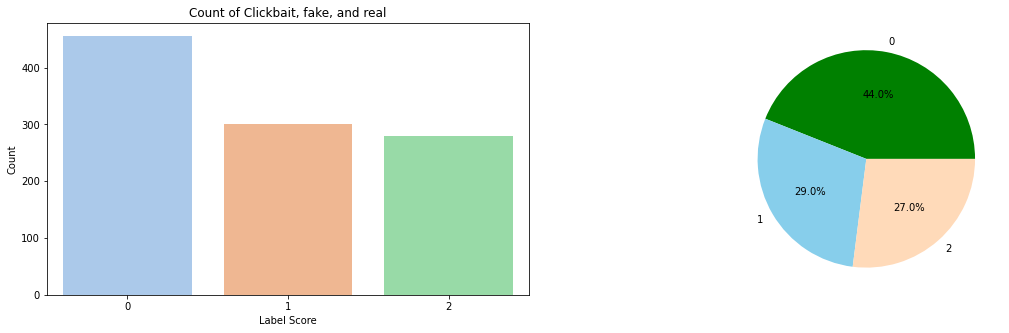

In [47]:
print(datasetfinal["label_score"].value_counts())
fig, ax = plt.subplots(1,2, figsize=(19, 5))
g1 = sns.countplot(datasetfinal.label_score,ax=ax[0],palette="pastel");
g1.set_title("Count of Clickbait, fake, and real")
g1.set_ylabel("Count")
g1.set_xlabel("Label Score")
g2 = plt.pie(datasetfinal["label_score"].value_counts().values,explode=[0,0,0],labels=datasetfinal.label_score.value_counts().index, autopct='%1.1f%%',colors=['Green','SkyBlue','PeachPuff'])
plt.show()

# Data Cleaning

## Menghapus HTML

In [48]:
def hapus_html(text):
    from bs4 import BeautifulSoup
    bs = BeautifulSoup(text, "html.parser")
    return bs.get_text()

datasetfinal['title text']=datasetfinal['title text'].apply(hapus_html)

C:\Users\Lenovo\anaconda\envs\tens_env\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


In [49]:
datasetfinal['title text']

0       Pelaku Pemukulan Brutal Terhadap Anak Anggota ...
1       Panglima Didukung Segera Tumpas Teroris KKB di...
2       CCIPP tingkatkan kualitas SDM untuk dukung IKN...
3       Survei SMRC: Kepuasan pada Kerja Jokowi Naik J...
4       Erick Thohir ajak Puan Retno dan Triawan ke Sa...
                              ...                        
1032    Penemuan Mayat Seorang Anak Kelas Satu SDN Pad...
1033    NOMOR PORSI HAJI KEBERANGKATAN TAHUN 2018 HING...
1034             Indonesia ku sayang, Indonesia ku malang
1035            PEMOGE TEWAS DI JALUR ALTERNATIF CIKIDANG
1036                    Gedung Kementrian Pun Akan Dijual
Name: title text, Length: 1037, dtype: object

## Menghapus Punctuation

In [50]:
def remove_punctuations(text):
    text = re.sub(r'[^a-zA-z0-9]', ' ', str(text))
    text = re.sub(r'\b\w{1,2}\b', '', text)
    text = re.sub(r'\s\s+', ' ', text)
    return text


datasetfinal['title text']=datasetfinal['title text'].apply(remove_punctuations)
datasetfinal

,title text,label,label_score
0,Pelaku Pemukulan Brutal Terhadap Anak Anggota ...,true,2
1,Panglima Didukung Segera Tumpas Teroris KKB Pa...,true,2
2,CCIPP tingkatkan kualitas SDM untuk dukung IKN...,true,2
3,Survei SMRC Kepuasan pada Kerja Jokowi Naik Jadi,true,2
4,Erick Thohir ajak Puan Retno dan Triawan Sarin...,true,2
...,...,...,...
1032,Penemuan Mayat Seorang Anak Kelas Satu SDN Pad...,false,1
1033,NOMOR PORSI HAJI KEBERANGKATAN TAHUN 2018 HING...,false,1
1034,Indonesia sayang Indonesia malang,false,1
1035,PEMOGE TEWAS JALUR ALTERNATIF CIKIDANG,false,1


## Case Folding

In [51]:
#Case Folding
def case_folding(text):
    return str.lower(text)

datasetfinal['title text']=datasetfinal['title text'].apply(case_folding)
datasetfinal

,title text,label,label_score
0,pelaku pemukulan brutal terhadap anak anggota ...,true,2
1,panglima didukung segera tumpas teroris kkb pa...,true,2
2,ccipp tingkatkan kualitas sdm untuk dukung ikn...,true,2
3,survei smrc kepuasan pada kerja jokowi naik jadi,true,2
4,erick thohir ajak puan retno dan triawan sarin...,true,2
...,...,...,...
1032,penemuan mayat seorang anak kelas satu sdn pad...,false,1
1033,nomor porsi haji keberangkatan tahun 2018 hing...,false,1
1034,indonesia sayang indonesia malang,false,1
1035,pemoge tewas jalur alternatif cikidang,false,1


In [52]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Error loading stopwords: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading punkt: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


False

In [53]:
stop_words = stopwords.words('indonesian')

In [54]:
stop_words.extend(["iyahhh","xixixi","awaninews","awani745"])

In [55]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
factory = StemmerFactory()
stemmer = factory.create_stemmer()
def removestopword_stemming(text):
    filter_sentence = []
    text = nltk.word_tokenize(text)
    
    for word in text:
        if word not in set(stop_words):
            factory = StemmerFactory() 
            stemmer = factory.create_stemmer()
            filter_sentence.append(stemmer.stem(word))
    return " ".join(filter_sentence)

datasetfinal['title text']=datasetfinal['title text'].apply(removestopword_stemming)
datasetfinal

,title text,label,label_score
0,laku pukul brutal anak anggota dpr tol tangkap,true,2
1,panglima dukung tumpas teroris kkb papua indon...,true,2
2,ccipp tingkat kualitas sdm dukung ikn diklat,true,2
3,survei smrc puas kerja jokowi,true,2
4,erick thohir ajak puan retno triawan sarinah l...,true,2
...,...,...,...
1032,temu mayat anak kelas sdn pademangan barat mayor,false,1
1033,nomor porsi haji berangkat 2018 2030,false,1
1034,indonesia sayang indonesia malang,false,1
1035,pemoge tewas jalur alternatif cikidang,false,1


In [56]:
datasetfinal.rename(columns = {"title text": "title_text"}, inplace=True)

In [57]:
datasetfinal['label_score'].value_counts()

0    456
1    301
2    280
Name: label_score, dtype: int64

In [58]:
datasetfinal['title_text'].iloc[0]

'laku pukul brutal anak anggota dpr tol tangkap'

In [59]:
len(datasetfinal['title_text'].iloc[0])

46

# Visualization WordCloud

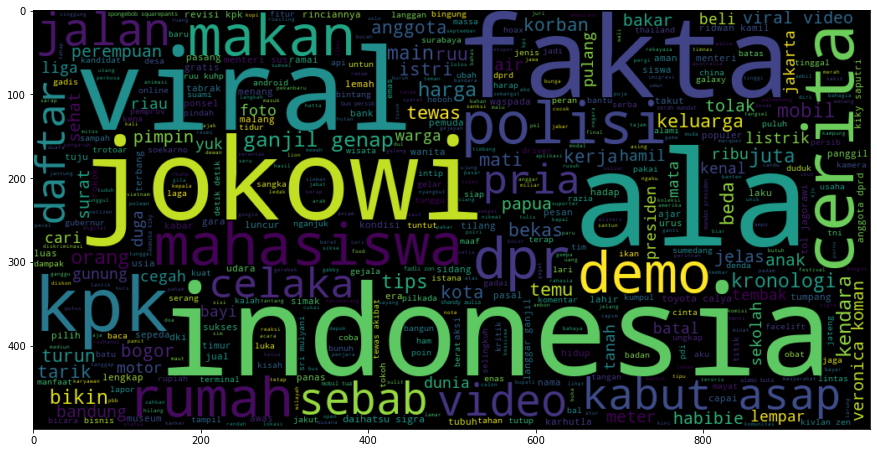

In [60]:
from wordcloud import WordCloud,STOPWORDS
plt.figure(figsize = (15,15))
wc = WordCloud(max_words = 500 , width = 1000 , height = 500 , stopwords = STOPWORDS).generate(" ".join(datasetfinal[datasetfinal.label_score == 0].title_text))
plt.imshow(wc , interpolation = 'bilinear')

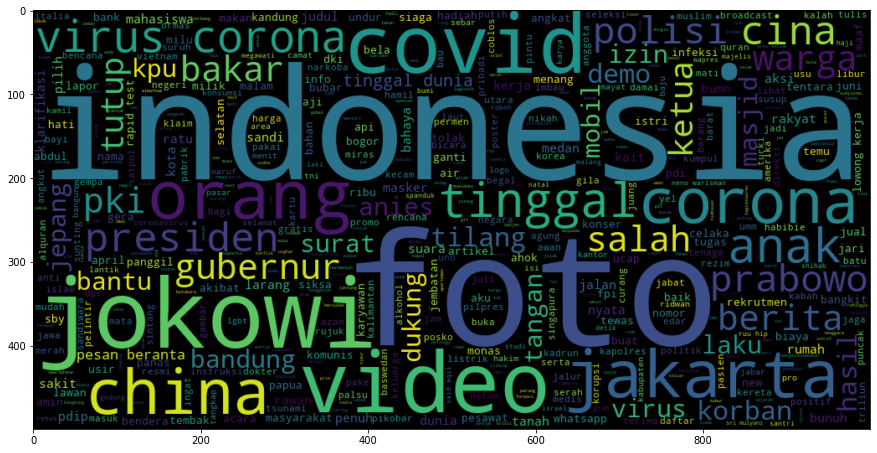

In [61]:
plt.figure(figsize = (15,15))
wc = WordCloud(max_words = 500 , width = 1000 , height = 500 , stopwords = STOPWORDS).generate(" ".join(datasetfinal[datasetfinal.label_score == 1].title_text))
plt.imshow(wc , interpolation = 'bilinear')

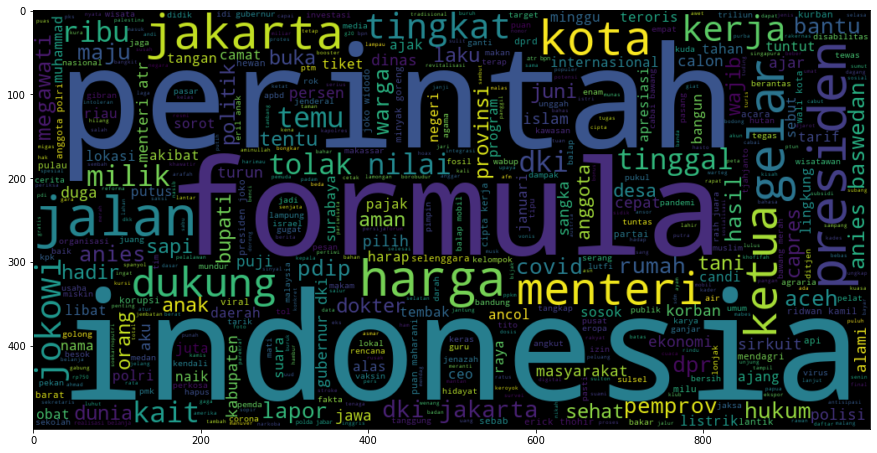

In [62]:
plt.figure(figsize = (15,15))
wc = WordCloud(max_words = 500 , width = 1000 , height = 500 , stopwords = STOPWORDS).generate(" ".join(datasetfinal[datasetfinal.label_score == 2].title_text))
plt.imshow(wc , interpolation = 'bilinear')

In [63]:
datasetfinal.head(10)

,title_text,label,label_score
0,laku pukul brutal anak anggota dpr tol tangkap,true,2
1,panglima dukung tumpas teroris kkb papua indon...,true,2
2,ccipp tingkat kualitas sdm dukung ikn diklat,true,2
3,survei smrc puas kerja jokowi,true,2
4,erick thohir ajak puan retno triawan sarinah l...,true,2
5,dokter tinggal vaksin,true,2
6,cuaca buruk harga cabai bawang merah bandung l...,true,2
7,achoy suara tujuh sedia musprovlub bola tangan...,true,2
8,jalan wisata desa mangli rusak unjung wisata j...,true,2
9,ridwan kamil sosok eril anak yatim duafa,true,2


In [64]:
datasetfinal['label_score'].value_counts()

0    456
1    301
2    280
Name: label_score, dtype: int64

In [65]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()
bebas = []
for index,row in datasetfinal.iterrows():
    sentence = row['title_text']
    words = nltk.word_tokenize(sentence)
    words = [stemmer.stem(word) for word in words if not word in stop_words]
    words = ' '.join(words)
    bebas.append(words)

In [66]:
bebas[0]

'laku brutal anak anggota dpr tol tangkap'

# Load Word Embedding

In [69]:
print('loading word embeddings...')
embeddings_index = {}
f = codecs.open('cc.id.300.vec', encoding='utf-8')
for line in tqdm(f):
    values = line.rstrip().rsplit(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('found %s word vectors' % len(embeddings_index))

loading word embeddings...


2000001it [02:50, 11760.75it/s]

found 2000000 word vectors


In [70]:
embeddings_index['hello'].shape

(300,)

# Train and Test

In [71]:
# Time
import time
import datetime

# print date and time for given type of representation
def date_time(x):
    if x==1:
        return 'Timestamp: {:%Y-%m-%d %H:%M:%S}'.format(datetime.datetime.now())
    if x==2:    
        return 'Timestamp: {:%Y-%b-%d %H:%M:%S}'.format(datetime.datetime.now())
    if x==3:  
        return 'Date now: %s' % datetime.datetime.now()
    if x==4:  
        return 'Date today: %s' % datetime.date.today() 

In [72]:
output_directory = r"../output/"
main_model_dir = output_directory + r"models/"
main_log_dir = output_directory + r"logs/"

try:
    os.mkdir(main_model_dir)
except:
    print("Could not create main model directory")
    
try:
    os.mkdir(main_log_dir)
except:
    print("Could not create main log directory")



model_dir = main_model_dir + time.strftime('%Y-%m-%d %H-%M-%S') + "/"
log_dir = main_log_dir + time.strftime('%Y-%m-%d %H-%M-%S')


try:
    os.mkdir(model_dir)
except:
    print("Could not create model directory")
    
try:
    os.mkdir(log_dir)
except:
    print("Could not create log directory")
    
model_file = model_dir + "{epoch:02d}-val_acc-{val_acc:.2f}-val_loss-{val_loss:.2f}.hdf5"

Could not create main model directory
Could not create main log directory
Could not create model directory
Could not create log directory


In [73]:
print("Settting Callbacks")

checkpoint = ModelCheckpoint(
    model_file, 
    monitor='val_acc', 
    save_best_only=True)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    verbose=1,
    restore_best_weights=True)


reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=1,
    verbose=1)


callbacks = [checkpoint, reduce_lr, early_stopping]

callbacks = [early_stopping]

print("Set Callbacks at ", date_time(1))

Settting Callbacks
Set Callbacks at  Timestamp: 2022-08-11 08:15:39


In [74]:
import tensorflow

In [75]:
from tensorflow.keras.utils import to_categorical

X = datasetfinal.title_text
Y = datasetfinal.label

label_encoder = LabelEncoder()

Y = label_encoder.fit_transform(Y)

Y = to_categorical(Y)

# Y = Y.reshape(-1, 1)
Y

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.]], dtype=float32)

In [77]:
X

0          laku pukul brutal anak anggota dpr tol tangkap
1       panglima dukung tumpas teroris kkb papua indon...
2            ccipp tingkat kualitas sdm dukung ikn diklat
3                           survei smrc puas kerja jokowi
4       erick thohir ajak puan retno triawan sarinah l...
                              ...                        
1032     temu mayat anak kelas sdn pademangan barat mayor
1033                 nomor porsi haji berangkat 2018 2030
1034                    indonesia sayang indonesia malang
1035               pemoge tewas jalur alternatif cikidang
1036                                      gedung tri jual
Name: title_text, Length: 1037, dtype: object

In [79]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1)

print("num train: ", X_train.shape[0])
print("num test: ", X_test.shape[0])

max_words = len(set(" ".join(X_train).split()))
max_len = X_train.apply(lambda x: len(x)).max()

# max_words = 1000
# max_len = 150
max_words, max_len

num train:  933
num test:  104


(3051, 149)

In [80]:
tokenizer = Tokenizer(num_words=max_words)

tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_train_seq = sequence.pad_sequences(X_train_seq, maxlen=max_len)

X_test_seq = tokenizer.texts_to_sequences(X_test)
X_test_seq = sequence.pad_sequences(X_test_seq, maxlen=max_len)

word_index = tokenizer.word_index
print("dictionary size: ", len(word_index))

dictionary size:  3051


In [81]:
#model parameters
num_filters = 64 
embed_dim = 300 
weight_decay = 1e-4

In [82]:
#embedding matrix
print('preparing embedding matrix...')
words_not_found = []
nb_words = min(max_words, len(word_index))
embedding_matrix = np.zeros((nb_words, embed_dim))
for word, i in word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)
print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 175


In [83]:
print("sample words not found: ", np.random.choice(words_not_found, 15))

sample words not found:  ['realme' 'dagel' 'parekraf' 'pwi' 'geoge' 'pemoge' 'margolin' 'betrand'
 'ppkm' 'tjimanoek' 'kpai' 'warisman' 'parekraf' 'pppk' 'omid']


In [86]:
from tensorflow.keras.layers import BatchNormalization

In [87]:
def get_rnn_model(num_class=2):
    model = Sequential()
    
    model.add(Embedding(nb_words, embed_dim, weights=[embedding_matrix], input_length=max_len))
    model.add(LSTM(256))
    
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Dense(512, activation='relu'))
    
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    if num_class>2:
        model.add(Dense(num_class, activation='softmax'))
    else:
        model.add(Dense(1, activation='sigmoid'))
    
    model.summary()
    
    return model

In [88]:
num_class = 3
model1 = get_rnn_model(num_class=num_class)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 149, 300)          915300    
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               570368    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               131584    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)              

In [92]:
loss = 'categorical_crossentropy'
metrics = ['accuracy']

In [93]:
from tensorflow.keras.optimizers import RMSprop, Adam
print("Starting...\n")

start_time = time.time()
print(date_time(1))

print("\n\nCompliling Model ...\n")
learning_rate = 0.001
optimizer = Adam(learning_rate)
# optimizer = Adam()

model1.compile(optimizer=optimizer, loss=loss, metrics=metrics)

verbose = 1
epochs = 100
batch_size = 128
validation_split = 0.1
#use to validate performance model during training

print("Trainning Model ...\n")

history1 = model1.fit(
    X_train_seq,
    Y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=verbose,
    validation_split=validation_split,
    )

Starting...

Timestamp: 2022-08-11 08:24:15


Compliling Model ...

Trainning Model ...

Epoch 1/100
7/7 [==============================] - 6s 462ms/step - loss: 2.0227 - accuracy: 0.3445 - val_loss: 1.0914 - val_accuracy: 0.3617
Epoch 2/100
7/7 [==============================] - 3s 387ms/step - loss: 1.7311 - accuracy: 0.3754 - val_loss: 1.0917 - val_accuracy: 0.3617
Epoch 3/100
7/7 [==============================] - 3s 380ms/step - loss: 1.5326 - accuracy: 0.4696 - val_loss: 1.0928 - val_accuracy: 0.3617
Epoch 4/100
7/7 [==============================] - 4s 631ms/step - loss: 1.2464 - accuracy: 0.5256 - val_loss: 1.1072 - val_accuracy: 0.3617
Epoch 5/100
7/7 [==============================] - 5s 745ms/step - loss: 1.1135 - accuracy: 0.5936 - val_loss: 1.0950 - val_accuracy: 0.3617
Epoch 6/100
7/7 [==============================] - 4s 613ms/step - loss: 0.8178 - accuracy: 0.6782 - val_loss: 1.0568 - val_accuracy: 0.4043
Epoch 7/100
7/7 [==============================] - 4s 611ms/step 

Epoch 58/100
7/7 [==============================] - 4s 576ms/step - loss: 0.0036 - accuracy: 0.9988 - val_loss: 0.9059 - val_accuracy: 0.6489
Epoch 59/100
7/7 [==============================] - 4s 595ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.9371 - val_accuracy: 0.6383
Epoch 60/100
7/7 [==============================] - ETA: 0s - loss: 0.0022 - accuracy: 1.00 - 5s 663ms/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 0.9160 - val_accuracy: 0.6596
Epoch 61/100
7/7 [==============================] - 4s 599ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.8948 - val_accuracy: 0.6489
Epoch 62/100
7/7 [==============================] - 4s 594ms/step - loss: 0.0026 - accuracy: 1.0000 - val_loss: 0.9055 - val_accuracy: 0.6383
Epoch 63/100
7/7 [==============================] - 4s 601ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.9233 - val_accuracy: 0.6383
Epoch 64/100
7/7 [==============================] - 5s 639ms/step - loss: 0.0014 - accuracy: 1.0000 - val_

In [95]:
test_X_seq = tokenizer.texts_to_sequences(X_test)
test_X_seq = sequence.pad_sequences(test_X_seq, maxlen=max_len)
accuracy1 = model1.evaluate(test_X_seq, Y_test)

4/4 [==============================] - 0s 43ms/step - loss: 1.6291 - accuracy: 0.6731


In [96]:
print("Model Performance of RNN (Test Accuracy):")
print('Accuracy: {:0.2f}%\nLoss: {:0.3f}\n'.format(accuracy1[1]*100, accuracy1[0]))

Model Performance of RNN (Test Accuracy):
Accuracy: 67.31%
Loss: 1.629



In [97]:
ypreds1 = model1.predict(test_X_seq, verbose=1)

4/4 [==============================] - 0s 27ms/step


In [98]:
print(classification_report(Y_test, ypreds1>0.5))

              precision    recall  f1-score   support

           0       0.69      0.82      0.75        45
           1       0.69      0.65      0.67        34
           2       0.69      0.44      0.54        25

   micro avg       0.69      0.67      0.68       104
   macro avg       0.69      0.64      0.65       104
weighted avg       0.69      0.67      0.67       104
 samples avg       0.67      0.67      0.67       104



C:\Users\Lenovo\anaconda\envs\tens_env\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


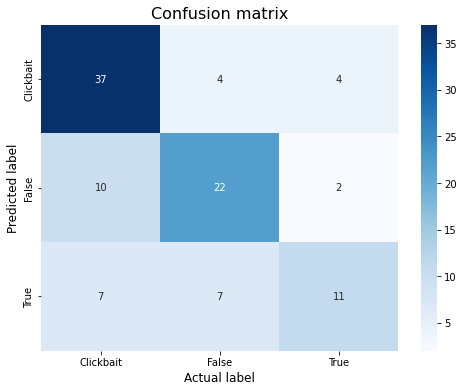

In [99]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, X_test, Y_test):
    '''Function to plot confusion matrix for the passed model and the data'''
    
    sentiment_classes = ['Clickbait', 'False', 'True']
    # use model to do the prediction
    # compute confusion matrix
    cm = confusion_matrix(np.argmax(np.array(Y_test),axis=1), np.argmax(ypreds1, axis=1))
    # plot confusion matrix
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d', 
                xticklabels=sentiment_classes,
                yticklabels=sentiment_classes)
    plt.title('Confusion matrix', fontsize=16)
    plt.xlabel('Actual label', fontsize=12)
    plt.ylabel('Predicted label', fontsize=12)
    
plot_confusion_matrix(model1, X_test, Y_test)

In [100]:
# Save the model architecture & the weights
model1.save('best_model.h5')
print('Best model saved')

Best model saved


In [101]:
from keras.models import load_model

# Load model
model = load_model('best_model.h5')

def predict_class(text):
    '''Function to predict news'''
    
    news_classes = ['Clickbait', 'False', 'True']
    max_len=50
    
    # Transforms text to a sequence of integers using a tokenizer object
    xt = tokenizer.texts_to_sequences(text)
    # Pad sequences to the same length
    xt = pad_sequences(xt, padding='post', maxlen=max_len)
    print(xt)
    # Do the prediction using the loaded model
    yt = model.predict(xt).argmax(axis=1)
    # Print the predicted sentiment
    print(yt)
    print('The predicted news is', news_classes[yt[0]])

In [102]:
predict_class(["Heboh! Ini Yang Dilakukan Ariel Pada Celine di Panggung"])

[[595   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0]]
[1]
The predicted news is False
